## Text preprocessing
1. Read lines from file and remove non-alphanumeric tokens(except space and apostrophe to keep the format)
2. Create vocabulary list from the lines
3. Put BEG, END, PAD, UNK into voc-index mapping list.
4. Create mapping lists between vocabularies and indices while dropping rare vacabularies.
5. Encode lines to indices lists also add BEG and END.
6. Drop the lines with UNK words.
7. Form dialog sets from lines in proper length.
8. Find max length which is most likely the threshold we set in 7th step

## Batch preparation
Create encoder's input, decoder's input and output based on dialog sets above.
Perform padding by adding PAD.

## Model training
Train the seq2seq model with 40 epochs and record the loss at each epoch. 

## Cherry pick
Randomly pick inputs and predict their outputs.  We sort the results based on similarity(BLEU score) and print out top predictions. 

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
import numpy as np

lines = []
file = open('./dataset/chatbot/conversations.txt', 'r')
for line in file:
     lines.append(line)
        
file.close()

In [3]:
allowed_ch = []
allowed_ch.append(chr(39)) #'
allowed_ch.append(chr(32)) #space
for i in range(97,97+26):
    allowed_ch.append(chr(i))

print(allowed_ch)

["'", ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
dat = []
for line in lines:
    new_l =''
    for w in line.split():
        s = ''.join([letter for letter in w if letter in allowed_ch])
        new_l += ' ' + s
    dat.append(new_l)

print(dat[:10])

[' can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again', " well i thought we'd start with pronunciation if that's okay with you", ' not the hacking and gagging and spitting part please', " okay then how 'bout we try out some french cuisine saturday night", '', " you're asking me out that's so cute what's your name again", ' forget it', '', " no no it's my fault  we didn't have a proper introduction ", ' cameron']


In [5]:
vocab = dict()

def add_vocab(w):
    if(len(w)) < 1:
        return
    if not w in vocab:
        vocab[w] = 1
    else:
        vocab[w] += 1

In [6]:
for line in dat:
    for w in line.split():
        add_vocab(w)

In [7]:
thrhd = 60
count = 0
for k,v in vocab.items():
    if v >= thrhd:
        count += 1

In [8]:
print("Size of total vocab:", len(vocab))
print("Size of vocab we will use:", count)

Size of total vocab: 67977
Size of vocab we will use: 2970


In [9]:
import _pickle as cPickle
def build_voc_mapping(voc_cnt, thrhd):
  """
    enc_map: voc --encode--> id
    dec_map: id --decode--> voc
    """

  def add(enc_map, dec_map, voc):
    enc_map[voc] = len(dec_map)
    dec_map[len(dec_map)] = voc
    return enc_map, dec_map

  # add <ST>, <ED>, <RARE>
  enc_map, dec_map = {}, {}
  for voc in ['<BEG>', '<END>', '<UNK>', '<PAD>']:
    enc_map, dec_map = add(enc_map, dec_map, voc)
  for voc, cnt in voc_cnt.items():
    if int(cnt) < thrhd:  # rare words => <RARE>
      enc_map[voc] = enc_map['<UNK>']
    else:
      enc_map, dec_map = add(enc_map, dec_map, voc)
  return enc_map, dec_map


enc_map, dec_map = build_voc_mapping(vocab, thrhd)
# save enc/decoding map to disk
cPickle.dump(enc_map, open('./enc_map.pkl', 'wb'))
cPickle.dump(dec_map, open('./dec_map.pkl', 'wb'))

In [10]:
def lines_to_ids(enc_map, dat):
  lines_ids = []
  for line in dat:   
    icap = [enc_map[x] for x in line.split()]
    icap.insert(0, enc_map['<BEG>'])
    icap.append(enc_map['<END>'])
    lines_ids.append(icap)
  return lines_ids


enc_map = cPickle.load(open('./enc_map.pkl', 'rb'))

dat_proc = lines_to_ids(enc_map, dat)

In [11]:
dat_clean = []

for i in range(len(dat_proc)):
  if not (enc_map['<UNK>'] in dat_proc[i]):  # remove '<UNK>' sentence
    dat_clean.append(dat_proc[i])

In [12]:
print(dat_clean[:10])

[[0, 1], [0, 1439, 2356, 2855, 2542, 335, 2766, 519, 550, 1297, 1126, 154, 1], [0, 2344, 1588, 1], [0, 1], [0, 1592, 1742, 836, 1566, 1517, 2698, 2261, 612, 2767, 1], [0, 1], [0, 1543, 1], [0, 335, 2698, 1448, 1], [0, 1], [0, 1690, 2855, 2315, 1990, 1311, 1087, 1671, 1]]


In [13]:
print('data usage {}'.format(len(dat_clean)/len(dat)*100))

data usage 63.27247879116062


In [14]:
word_count = 0
unk_count = 0

for line in dat_clean:
    for w in line:
        if w == enc_map["<UNK>"]:
            unk_count += 1
        word_count += 1
    
unk_ratio = round(unk_count/word_count,4)*100
    
print("Total number of words:", word_count)
print("Number of times <UNK> is used:", unk_count)
print("Percent of words that are <UNK>: {}%".format(round(unk_ratio,3)))

Total number of words: 1493077
Number of times <UNK> is used: 0
Percent of words that are <UNK>: 0.0%


In [15]:
xs_corpus = []
ys_corpus = []

for i in range(len(dat_clean)-1):
    xs = dat_clean[i]
    ys = dat_clean[i+1]
    if len(xs) > 20 or len(xs) < 3 or len(ys) > 20 or len(ys) < 3:
        continue
    xs_corpus.append(xs)
    ys_corpus.append(ys)

In [16]:
enc_map = cPickle.load(open('./enc_map.pkl', 'rb'))  # token => id
dec_map = cPickle.load(open('./dec_map.pkl', 'rb'))  # id => token
vocab_size = len(dec_map)

for i in range(10):
    print(' '.join([dec_map[idx] for idx in xs_corpus[i]]))
    print(' '.join([dec_map[idx] for idx in ys_corpus[i]]))
    print('\n')

<BEG> you're asking me out that's so cute what's your name again <END>
<BEG> forget it <END>


<BEG> why <END>
<BEG> that's a shame <END>


<BEG> that's because it's such a nice one <END>
<BEG> forget french <END>


<BEG> there <END>
<BEG> where <END>


<BEG> you have my word as a gentleman <END>
<BEG> you're sweet <END>


<BEG> sure have <END>
<BEG> i really really really wanna go but i can't not unless my sister goes <END>


<BEG> i really really really wanna go but i can't not unless my sister goes <END>
<BEG> i'm workin' on it but she doesn't seem to be goin' for him <END>


<BEG> she's not a <END>
<BEG> so that's the kind of guy she likes pretty ones <END>


<BEG> hi <END>
<BEG> looks like things worked out tonight huh <END>


<BEG> well no <END>
<BEG> then that's all you had to say <END>




In [17]:
xs_max_len = 0
ys_max_len = 0

for i in range(len(xs_corpus)):  # caculate max length
  xs_max_len = max(xs_max_len, len(xs_corpus[i]))
  ys_max_len = max(ys_max_len, len(ys_corpus[i]))

print(xs_max_len, ys_max_len)

20 20


In [23]:
class BatchGenerator:

  def __init__(self, xs_corpus, ys_corpus, xs_pad, ys_pad, xs_max_len, ys_max_len, batch_size):
    n = len(xs_corpus)
    batch_num = len(xs_corpus) // batch_size
    n = batch_num * batch_size

    self.xs = [np.zeros(n, dtype=np.int32)
               for _ in range(xs_max_len)]  # encoder inputs
    self.ys = [np.zeros(n, dtype=np.int32)
               for _ in range(ys_max_len)]  # decoder inputs
    self.gs = [np.zeros(n, dtype=np.int32)
               for _ in range(ys_max_len)]  # decoder outputs
    self.ws = [np.zeros(n, dtype=np.float32)
               for _ in range(ys_max_len)]  # decoder weight for loss caculation

    self.xs_max_len = xs_max_len
    self.ys_max_len = ys_max_len
    self.batch_size = batch_size

    for b in range(batch_num):
        for i in range(b * batch_size, (b + 1) * batch_size):
            for j in range(len(xs_corpus[i]) - 2):
                self.xs[j][i] = xs_corpus[i][j + 1]
            for j in range(j + 1, xs_max_len):
                self.xs[j][i] = xs_pad

            for j in range(len(ys_corpus[i]) - 1):
                self.ys[j][i] = ys_corpus[i][j]
                self.gs[j][i] = ys_corpus[i][j + 1]
                self.ws[j][i] = 1.0
            for j in range(j + 1, ys_max_len):  # don't forget padding and let loss weight zero
                self.ys[j][i] = ys_pad
                self.gs[j][i] = ys_pad
                self.ws[j][i] = 0.0

  def get(self, batch_id):
    x = [
        self.xs[i][batch_id * self.batch_size:(batch_id + 1) * self.batch_size]
        for i in range(self.xs_max_len)
    ]
    y = [
        self.ys[i][batch_id * self.batch_size:(batch_id + 1) * self.batch_size]
        for i in range(self.ys_max_len)
    ]
    g = [
        self.gs[i][batch_id * self.batch_size:(batch_id + 1) * self.batch_size]
        for i in range(self.ys_max_len)
    ]
    w = [
        self.ws[i][batch_id * self.batch_size:(batch_id + 1) * self.batch_size]
        for i in range(self.ys_max_len)
    ]

    return x, y, g, w


batch = BatchGenerator(xs_corpus, ys_corpus, enc_map['<PAD>'],
                       enc_map['<PAD>'], xs_max_len, ys_max_len, 4)

In [19]:
x, y, g, w = batch.get(2)
for i in range(4):
  print(' '.join([dec_map[x[j][i]] for j in range(xs_max_len)]))
  print(' '.join([dec_map[y[j][i]] for j in range(ys_max_len)]))
  print(' '.join([dec_map[g[j][i]] for j in range(ys_max_len)]))
  print('')

hi <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
<BEG> looks like things worked out tonight huh <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
looks like things worked out tonight huh <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

well no <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
<BEG> then that's all you had to say <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
then that's all you had to say <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

then that's all you had to say <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
<BEG> but <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
but <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

In [18]:
import tensorflow as tf

In [19]:
class MachineTranslationSeq2Seq:

  def __init__(self, xs_max_len, ys_max_len, xs_size, ys_size):
    self.xs_max_len = xs_max_len
    self.ys_max_len = ys_max_len

    with tf.variable_scope('seq2seq_intput/output'):
      self.enc_inputs = [
          tf.placeholder(tf.int64, [None]) for i in range(xs_max_len)
      ]  # time mojor feed
      self.dec_inputs = [
          tf.placeholder(tf.int64, [None]) for i in range(ys_max_len)
      ]
      self.groundtruths = [
          tf.placeholder(tf.int64, [None]) for i in range(ys_max_len)
      ]
      self.weights = [
          tf.placeholder(tf.float32, [None]) for i in range(ys_max_len)
      ]

    with tf.variable_scope('seq2seq_rnn'):  # training by teacher forcing
      self.out_cell = tf.contrib.rnn.LSTMCell(512)
      self.outputs, _ = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
          self.enc_inputs, self.dec_inputs, self.out_cell, xs_size, ys_size,
          300)
    with tf.variable_scope(
        'seq2seq_rnn', reuse=True):  # predict by feeding previous
      self.pred_cell = tf.contrib.rnn.LSTMCell(
          512, reuse=True)  # reuse cell for train and test
      self.predictions, _ = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
          self.enc_inputs,
          self.dec_inputs,
          self.pred_cell,
          xs_size,
          ys_size,
          300,
          feed_previous=True)

    with tf.variable_scope('loss'):
      # caculate weighted loss
      self.loss = tf.reduce_mean(
          tf.contrib.legacy_seq2seq.sequence_loss_by_example(
              self.outputs, self.groundtruths, self.weights))
      self.optimizer = tf.train.AdamOptimizer(0.002).minimize(self.loss)

    self.sess = tf.Session()
    self.saver = tf.train.Saver()
    self.sess.run(tf.global_variables_initializer())

  def train(self, x, y, g, w):
    fd = {}
    for i in range(self.xs_max_len):
      fd[self.enc_inputs[i]] = x[i]  # show how to feed a list

    for i in range(self.ys_max_len):
      fd[self.dec_inputs[i]] = y[i]
      fd[self.groundtruths[i]] = g[i]
      fd[self.weights[i]] = w[i]

    loss, _ = self.sess.run([self.loss, self.optimizer], fd)

    return loss

  def output(self, x, y):
    fd = {}
    for i in range(self.xs_max_len):
      fd[self.enc_inputs[i]] = x[i]

    for i in range(self.ys_max_len):
      fd[self.dec_inputs[i]] = y[i]

    out = self.sess.run(self.outputs, fd)

    return out

  def predict(self, x, ys_beg):
    fd = {}
    for i in range(self.xs_max_len):
      fd[self.enc_inputs[i]] = x[i]

    for i in range(self.ys_max_len):  
    # when feed previous, the fist token should be '<BEG>', and others are useless
      if i == 0:
        fd[self.dec_inputs[i]] = np.ones(y[i].shape, dtype=np.int32) * ys_beg
      else:
        fd[self.dec_inputs[i]] = np.zeros(y[i].shape, dtype=np.int32)

    pd = self.sess.run(self.predictions, fd)

    return pd

  def save(self, e):
    self.saver.save(self.sess, 'model/seq2seq/seq2seq_%d.ckpt' % (e + 1))

  def restore(self, e):
    self.saver.restore(self.sess, 'model/seq2seq/seq2seq_%d.ckpt' % (e))

In [20]:
tf.reset_default_graph()
model = MachineTranslationSeq2Seq(xs_max_len, ys_max_len,
                                  len(enc_map), len(dec_map))

In [24]:
EPOCHS = 40
BATCH_SIZE = 200
batch_num = len(xs_corpus) // BATCH_SIZE

batch = BatchGenerator(xs_corpus, ys_corpus, enc_map['<PAD>'],
                       enc_map['<PAD>'], xs_max_len, ys_max_len, BATCH_SIZE)

In [24]:
rec_loss = []
for e in range(EPOCHS):
  train_loss = 0

  for b in range(batch_num):
    if b % 100 ==0: print(b)
    x, y, g, w = batch.get(b)
    batch_loss = model.train(x, 
                             y, g, w)
    train_loss += batch_loss

  train_loss /= batch_num
  print('EPOCH:{}, LOSS:{}'.format(e,train_loss))
  rec_loss.append(train_loss)
  model.save(e)

np.save('./model/seq2seq/rec_loss.npy', rec_loss)

0
100
200
300
400
EPOCH:0, LOSS:4.46940435315961
0
100
200
300
400
EPOCH:1, LOSS:3.913471751123945
0
100
200
300
400
EPOCH:2, LOSS:3.6703528951261646
0
100
200
300
400
EPOCH:3, LOSS:3.4097770196255124
0
100
200
300
400
EPOCH:4, LOSS:3.1376057562426984
0
100
200
300
400
EPOCH:5, LOSS:2.889105284882483
0
100
200
300
400
EPOCH:6, LOSS:2.6738659550096386
0
100
200
300
400
EPOCH:7, LOSS:2.4904117397615844
0
100
200
300
400
EPOCH:8, LOSS:2.3319309888599076
0
100
200
300
400
EPOCH:9, LOSS:2.193650005019714
0
100
200
300
400
EPOCH:10, LOSS:2.0740541729414574
0
100
200
300
400
EPOCH:11, LOSS:1.9781859063099478
0
100
200
300
400
EPOCH:12, LOSS:1.8896161081077896
0
100
200
300
400
EPOCH:13, LOSS:1.8120386260692205
0
100
200
300
400
EPOCH:14, LOSS:1.744707724201345
0
100
200
300
400
EPOCH:15, LOSS:1.6795706347884418
0
100
200
300
400
EPOCH:16, LOSS:1.622174625084779
0
100
200
300
400
EPOCH:17, LOSS:1.5713691129305651
0
100
200
300
400
EPOCH:18, LOSS:1.5339131901197345
0
100
200
300
400
EPOCH:19, L

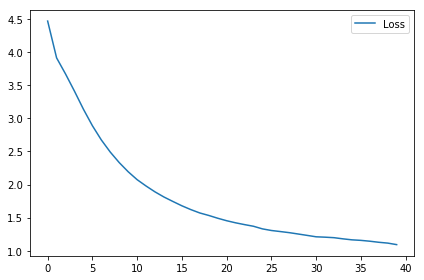

In [27]:
rec_loss = np.load('./model/seq2seq/rec_loss.npy')

import matplotlib.pyplot as plt

plt_loss = plt.plot([rec_loss[i] for i in range(len(rec_loss))])
plt.legend(['Loss'])
plt.tight_layout()
plt.savefig('./LOSS.jpg', dpi=300)
plt.show()

In [25]:
model.restore(EPOCHS)

INFO:tensorflow:Restoring parameters from model/seq2seq/seq2seq_40.ckpt


In [34]:
import nltk


def cherry_pick(records, n, upper_bound=1.0):
  bleus = []

  for xs, ys_gr, ys_pd in records:
    bleu = nltk.translate.bleu_score.sentence_bleu(
        [ys_gr], ys_pd)  # caculate BLEU by nltk
    bleus.append(bleu)

  lst = [i for i in range(len(records)) if bleus[i] <= upper_bound]
  lst = sorted(lst, key=lambda i: bleus[i], reverse=True)  # sort by BLEU score

  return [records[lst[i]] for i in range(n)]

In [37]:
import random as rd

records = []

for i in range(10):
  i = rd.randint(0, batch_num - 1)  # random pick one to translate

  x, y, g, w = batch.get(i)
  out = model.output(x, y)
  pd = model.predict(x, enc_map['<BEG>'])

  for j in range(10):
    j = rd.randint(0, BATCH_SIZE - 1)

    xs = [dec_map[x[i][j]] for i in range(xs_max_len)]
    xs = xs[:xs.index('<PAD>')]
    ys_gr = [dec_map[g[i][j]] for i in range(ys_max_len)]
    if '<END>' in ys_gr:
      ys_gr = ys_gr[:ys_gr.index('<END>')]
    ys_pd = [dec_map[np.argmax(pd[i][j, :])] for i in range(ys_max_len)]
    if '<END>' in ys_pd:
      ys_pd = ys_pd[:ys_pd.index('<END>')]

    records.append([xs, ys_gr, ys_pd])

n = 12  # how many result we show
rec_cherry = cherry_pick(records, n)

for i in range(n):
  for j in range(3):
    print(' '.join(rec_cherry[i][j]))

  print('')

nothing okay some of us have been a little not concerned exactly but
tell me
tell me

what do you suggest
that you come with me
that you come with me

it was my father's kept it in his wallet he was murdered
you sound so sure
you sound so sure

i guess i might as well get this done with
what should i do
what should i do

is that the kind of girl you think i am what can i do to make you relax
you could give me the gun
you could give me the gun

i'm her husband
husband
husband

at least i'll have company when i die ain't that right jake
for christ's sake john throw me the keys
for christ's sake john throw me the keys

now what's this
give it to me
give it to me

okay fine
fine fine what
fine fine what

oh this and that
what i've been doing
what i've been doing

well it's a living but i'm excited about this
what is it a still life
what is it a still life

can we have it by tonight
well if it's absolutely necessary
well if it's absolutely necessary



/home/chen/anaconda3/envs/tensorflow/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/chen/anaconda3/envs/tensorflow/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/chen/anaconda3/envs/tensorflow/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [38]:
%reset -sf